# Training Sample Generation for TempCNN approach to classify standing deadwood and cleaned forest areas

## Import necessary libraries

In [71]:
# TO DO erledigt
# 1 FCC Datum übernehmen aus Datensatz dem Trainingspoints nahe sind -> Codierung umrechnen in Datum
# 2 FCC Datum und Flight Datum abgleichen (bei zu großen Diskrepanzen Trainingspixel rausnehmen)
# 3 Zeitreihe anpassen (+- 6 Monate ab FCC Datum)

# TO DO morgen
# 1 Checken warum so wenige Zeitreihen extrahiert werden bzw. auch bei Points to FCC (-> Grenzpixel interpolieren?)
# 2 Zeitreihen plotten nach Klasse (ausgeräumt/Totholz)
# 3 Statistische Tests, ob sich Zeitreihen im Mittel voneinander unterscheiden oder so?

In [103]:
# Check if using the root_project environment
import sys
print(sys.executable)

/Users/christinakrause/anaconda3/envs/root_project/bin/python


In [2]:
import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np
from shapely.geometry import Point
from scipy.spatial import cKDTree
import os
import glob
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import rasterio
import seaborn as sns
print("All packages imported successfully!")

All packages imported successfully!


## Generate points with a specified spacing within polygons from a shapefile

In [3]:
# Change working directory
os.chdir('/Users/christinakrause/HIWI_DLR_Forest/')

In [4]:
def generate_points_from_polygons(geopackage_path, output_path, crs_epsg, spacing):
    # Load the shapefile
    polygons = gpd.read_file(geopackage_path)
    # Ensure CRS is epsg crs
    polygons = polygons.to_crs(epsg=crs_epsg)

    # List to store generated points
    points = []

    # Iterate over all polygons
    for idx, row in polygons.iterrows():
        polygon = row.geometry
        bounds = polygon.bounds  # (minx, miny, maxx, maxy)

        # Generates points within the bounding box
        x_coords = np.arange(bounds[0], bounds[2], spacing)
        y_coords = np.arange(bounds[1], bounds[3], spacing)

        for x in x_coords:
            for y in y_coords:
                point = Point(x, y)
                if polygon.contains(point):  # Ensure point is inside the polygon
                    point_attrs = row.copy()  # Copy attributes
                    point_attrs.geometry = point  # Replace geometry with point
                    points.append(point_attrs)

    # Create a new gdf
    points_gdf = gpd.GeoDataFrame(points, crs=polygons.crs)
    # Save as a new shapefile
    points_gdf.to_file(output_path)
    print(f"Point shapefile saved successfully at: {output_path}")
    return points_gdf

In [21]:
# Apply function
geopackage_path = "Data_Collection/polygons/training_polygons2022.gpkg"
output_path = "Data_Collection/points/training_points_10m_2022.gpkg"
training_points = generate_points_from_polygons(geopackage_path, output_path, crs_epsg=3035, spacing=10)
print(training_points)

Point shapefile saved successfully at: Data_Collection/points/training_points_10m_2022.gpkg
    id class Flight_Date Flight_Nr                         geometry
0    1     1  2022-07-18  119006/0  POINT (4422551.258 3035854.163)
0    1     1  2022-07-18  119006/0  POINT (4422551.258 3035864.163)
0    1     1  2022-07-18  119006/0  POINT (4422551.258 3035874.163)
0    1     1  2022-07-18  119006/0  POINT (4422551.258 3035884.163)
0    1     1  2022-07-18  119006/0  POINT (4422551.258 3035894.163)
..  ..   ...         ...       ...                              ...
16  17     2  2022-07-18  119006/0   POINT (4423571.532 3018803.49)
16  17     2  2022-07-18  119006/0   POINT (4423571.532 3018813.49)
16  17     2  2022-07-18  119006/0   POINT (4423571.532 3018823.49)
16  17     2  2022-07-18  119006/0   POINT (4423571.532 3018833.49)
16  17     2  2022-07-18  119006/0   POINT (4423571.532 3018843.49)

[3764 rows x 5 columns]


## Extract FCC code for training points

In [77]:
def extract_fcc_dates(fcc_path, points_gdf):
    with rasterio.open(fcc_path) as src:
        points = [(geom.x, geom.y) for geom in points_gdf.geometry]
        fcc_values = [val[0] for val in src.sample(points)]  # Extract raster values
    points_gdf['FCC_Value'] = fcc_values
    return points_gdf

In [78]:
# Apply function
fcc_path = 'Datenpaket_Beginn/fcc_15122024_bav.tiff'
training_points = extract_fcc_dates(fcc_path, training_points)
print(training_points)

    id class Flight_Nr Flight_Date                         geometry  FCC_Value
0    1     1  119005/0  2019-06-03   POINT (4435141.41 3026971.881)         44
0    1     1  119005/0  2019-06-03   POINT (4435141.41 3026981.881)         44
0    1     1  119005/0  2019-06-03   POINT (4435141.41 3026991.881)         44
0    1     1  119005/0  2019-06-03   POINT (4435151.41 3026961.881)         43
0    1     1  119005/0  2019-06-03   POINT (4435151.41 3026971.881)         43
..  ..   ...       ...         ...                              ...        ...
8    9     1  119006/0  2019-06-25  POINT (4454314.516 3023150.521)         66
8    9     1  119006/0  2019-06-25  POINT (4454314.516 3023160.521)         66
8    9     1  119006/0  2019-06-25  POINT (4454324.516 3023140.521)          0
8    9     1  119006/0  2019-06-25  POINT (4454324.516 3023150.521)         68
8    9     1  119006/0  2019-06-25  POINT (4454334.516 3023140.521)          0

[1026 rows x 6 columns]


## Convert FCC codes to standard date format

In [79]:
# Function to convert FCC values to dates using a lookup table
def convert_fcc_to_date(points_gdf, codierung_path):
    codierung_df = pd.read_excel(codierung_path)
    codierung_dict = dict(zip(codierung_df['FCC_Code'], codierung_df['Date']))
    points_gdf['FCC_Date'] = points_gdf['FCC_Value'].map(codierung_dict)
    return points_gdf

In [80]:
# Apply function 
fcc_codierung_path = 'Datenpaket_Beginn/Codierung_Schadzeitpunkte.xlsx'
training_points = convert_fcc_to_date(training_points, fcc_codierung_path)

## Filter out points with large discrepancies between FCC date and flight date and save dataframe

In [81]:
def filter_large_discrepancies(points_gdf, output_path, threshold_days=20):
    points_gdf['FCC_Date'] = pd.to_datetime(points_gdf['FCC_Date'])
    points_gdf['Flight_Date'] = pd.to_datetime(points_gdf['Flight_Date'])
    points_gdf['Date_Diff'] = abs((points_gdf['FCC_Date'] - points_gdf['Flight_Date']).dt.days)
    points_gdf = points_gdf[points_gdf['Date_Diff'] <= threshold_days]
    points_gdf.to_file(output_path)
    print(f"Point shapefile saved successfully at: {output_path}")
    return points_gdf

In [82]:
# Apply function 
output_path = "Data_Collection/points/training_points_10m_2019_filtered.gpkg"
training_points_filtered = filter_large_discrepancies(training_points, output_path)
print(training_points_filtered.count())
nan_count = training_points_filtered['Date_Diff'].isna().sum()
print(nan_count)

Point shapefile saved successfully at: Data_Collection/points/training_points_10m_2019_filtered.gpkg
id             42
class          42
Flight_Nr      42
Flight_Date    42
geometry       42
FCC_Value      42
FCC_Date       42
Date_Diff      42
dtype: int64
0


## Extract time series data from Disturbance Index NetCDF for filtered training points

In [22]:
def extract_time_series_from_netcdf(nc_path, points_gdf, output_folder, crs_epsg=3035):
    # Load the netCDF file and set CRS
    ds = xr.open_dataset(nc_path)
    ds = ds.rio.write_crs(f"EPSG:{crs_epsg}")

    # Extract coordinates from the netCDF
    x_coords = ds.x.values
    y_coords = ds.y.values

    # Create a grid of coordinates
    grid_points = np.array([(x, y) for x in x_coords for y in y_coords])

    # Build a KDTree for fast nearest-neighbor lookup
    tree = cKDTree(grid_points)

    # Empty dictionary to store time series data
    time_series_data = {}

    for idx, point in points_gdf.iterrows():
        x, y = point.geometry.x, point.geometry.y  # Extract point coordinates

        # Find the nearest pixel in netCDF
        dist, idx_nearest = tree.query([x, y])
        nearest_x, nearest_y = grid_points[idx_nearest]

        # Extract the time series for the nearest pixel
        time_series = ds.sel(x=nearest_x, y=nearest_y, method="nearest")

        # Convert Flight Date to datetime
        fcc_date = pd.to_datetime(point["Flight_Date"])

        # Define the time range (±6 months)
        start_date = fcc_date - pd.DateOffset(months=6)
        end_date = fcc_date + pd.DateOffset(months=6)

        # Filter time series within the range
        time_series = time_series.sel(time=slice(start_date, end_date))
        
        # Add all attributes from the point
        for attr in points_gdf.columns:
            if attr != "geometry":  # Skip geometry column
                time_series[attr] = point[attr]

        # Store time series
        time_series_data[idx] = time_series.to_dataframe()

        # Save time series to CSV
        time_series.to_dataframe().to_csv(f"{output_folder}/time_series_point_{idx}.csv")
    print("Time series extraction completed.")

In [23]:
# Apply function
nc_path = 'Datenpaket_Beginn/di_diff_biweek_42_35k.nc'
output_folder = 'Data_Collection/DI_points_timeseries_2022'
points_gdf = gpd.read_file("Data_Collection/points/training_points_10m_2022.gpkg")  # Load your points GeoDataFrame
print(points_gdf)
extract_time_series_from_netcdf(nc_path, points_gdf, output_folder)

      id class Flight_Date Flight_Nr                         geometry
0      1     1  2022-07-18  119006/0  POINT (4422551.258 3035854.163)
1      1     1  2022-07-18  119006/0  POINT (4422551.258 3035864.163)
2      1     1  2022-07-18  119006/0  POINT (4422551.258 3035874.163)
3      1     1  2022-07-18  119006/0  POINT (4422551.258 3035884.163)
4      1     1  2022-07-18  119006/0  POINT (4422551.258 3035894.163)
...   ..   ...         ...       ...                              ...
3759  17     2  2022-07-18  119006/0   POINT (4423571.532 3018803.49)
3760  17     2  2022-07-18  119006/0   POINT (4423571.532 3018813.49)
3761  17     2  2022-07-18  119006/0   POINT (4423571.532 3018823.49)
3762  17     2  2022-07-18  119006/0   POINT (4423571.532 3018833.49)
3763  17     2  2022-07-18  119006/0   POINT (4423571.532 3018843.49)

[3764 rows x 5 columns]
Time series extraction completed.


## Check if time series differ depending on class (1 cleared areas, 2 standing deadwood)

In [24]:
# Folder where CSVs are stored
output_folder = 'Data_Collection/DI_points_timeseries_2022'

# Get all CSV files
csv_files = glob.glob(os.path.join(output_folder, "*.csv"))

# Read and merge all CSVs
df_list = [pd.read_csv(f).assign(point_id=os.path.basename(f).split("_")[-1].split(".")[0]) for f in csv_files]
df = pd.concat(df_list, ignore_index=True)

# Ensure time column is in datetime format
df["time"] = pd.to_datetime(df["time"])

# Replace -2147483648 with NaN
df["di"] = df["di"].replace(-2147483648, np.nan)

# Check the first rows
print(df.head())

        time  quantile          x          y  band   di  spatial_ref  id  \
0 2022-02-01       0.1  4423085.0  3019065.0     1  2.0            0  16   
1 2022-02-15       0.1  4423085.0  3019065.0     1  2.0            0  16   
2 2022-03-01       0.1  4423085.0  3019065.0     1  2.0            0  16   
3 2022-03-15       0.1  4423085.0  3019065.0     1  2.0            0  16   
4 2022-04-01       0.1  4423085.0  3019065.0     1  2.0            0  16   

   class Flight_Date Flight_Nr point_id  
0      2  2022-07-18  119006/0     3738  
1      2  2022-07-18  119006/0     3738  
2      2  2022-07-18  119006/0     3738  
3      2  2022-07-18  119006/0     3738  
4      2  2022-07-18  119006/0     3738  


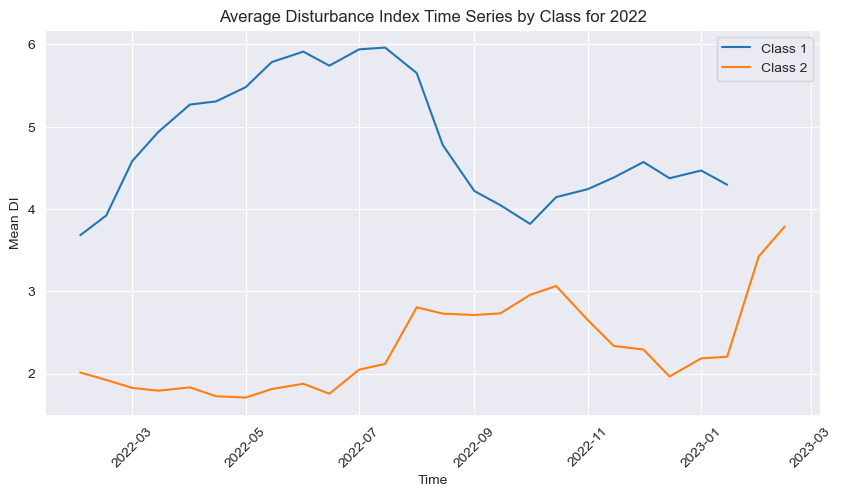

In [25]:
# Group by class and time, then compute mean DI and plot result
df_grouped = df.groupby(["class", "time"])["di"].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
for class_label in df_grouped["class"].unique():
    subset = df_grouped[df_grouped["class"] == class_label]
    plt.plot(subset["time"], subset["di"], label=f"Class {class_label}")

plt.xlabel("Time")
plt.ylabel("Mean DI")
plt.title("Average Disturbance Index Time Series by Class for 2022")
plt.legend()
plt.xticks(rotation=45)
plt.show()

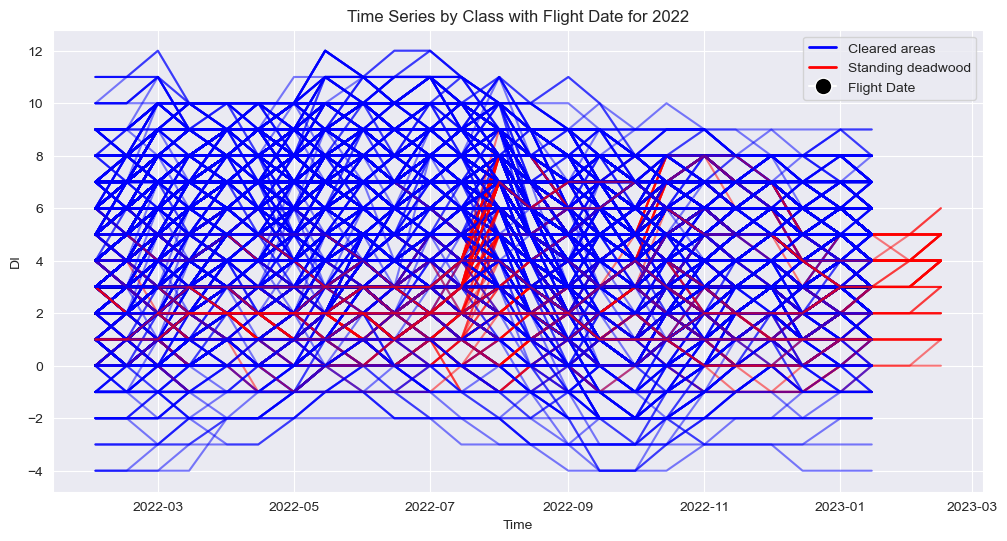

In [26]:
# Define colors for each class
class_colors = {1: "blue", 2: "red"}  # Class 1 → Blue, Class 2 → Red

df["Flight_Date"] = pd.to_datetime(df["Flight_Date"])
df["time"] = pd.to_datetime(df["time"])

plt.figure(figsize=(12, 6))

# Plot all time series, color by class
for point_id in df["point_id"].unique():
    subset = df[df["point_id"] == point_id]
    class_label = subset["class"].iloc[0]  # Get class of the point
    fcc_date = subset["Flight_Date"].iloc[0]  # Get FCC date for the point
    di_at_fcc = subset[subset["time"] == fcc_date]["di"].values  # Get DI value at FCC date

    plt.plot(subset["time"], subset["di"], alpha=0.5, color=class_colors[class_label])

    # Plot FCC_Date as a marker
    if len(di_at_fcc) > 0:  # Check if FCC date is in the time series
        plt.scatter(fcc_date, di_at_fcc[0], color=class_colors[class_label], edgecolor="black", zorder=3)

# Add labels and title
plt.xlabel("Time")
plt.ylabel("DI")
plt.title("Time Series by Class with Flight Date for 2022")

# Add legend manually
legend_elements = [
    Line2D([0], [0], color="blue", lw=2, label="Cleared areas"),
    Line2D([0], [0], color="red", lw=2, label="Standing deadwood"),
    Line2D([0], [0], marker="o", color="white", markerfacecolor="black", markersize=12, label="Flight Date"),
]
plt.legend(handles=legend_elements)

plt.show()

### Test difference of time series

In [27]:
# t-test: If data is normally distributed
from scipy.stats import ttest_ind

# Separate DI values by class
di_class1 = df[df["class"] == 1]["di"].dropna()
di_class2 = df[df["class"] == 2]["di"].dropna()

# Perform t-test
t_stat, p_value = ttest_ind(di_class1, di_class2, equal_var=False)

print(f"t-statistic = {t_stat}, p-value = {p_value}")


t-statistic = 123.13375125091324, p-value = 0.0


In [28]:
# Mann-Whitney U-test: If data is not normally distributed
from scipy.stats import mannwhitneyu
u_stat, p_value = mannwhitneyu(di_class1, di_class2, alternative="two-sided")
print(f"U-statistic = {u_stat}, p-value = {p_value}")

U-statistic = 461303003.5, p-value = 0.0


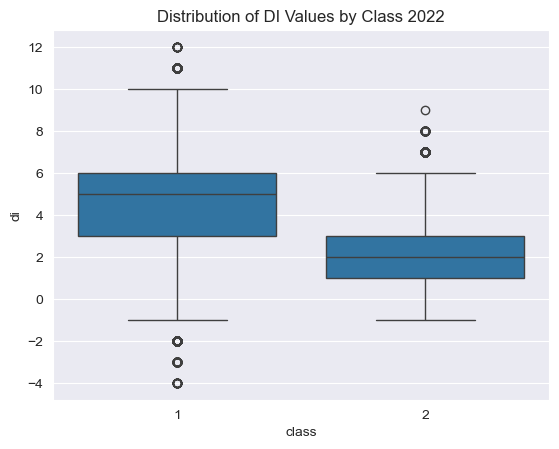

In [30]:
sns.boxplot(x="class", y="di", data=df)
plt.title("Distribution of DI Values by Class 2022")
plt.show()